# Laboratorio 1

## Integrantes: Esteicy Faerron, Carlos Morales y Cristopher McGuinness

### Se importan las bibliotecas:

In [1490]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from pydub import AudioSegment

### Para generar y aplicar enventanado de Hamming

In [1491]:
def get_window(type, length):
    window = list()
    if type == 'rectangular':
        for i in range(0, length):
            window.append(1)
    elif type == 'hamming':
        a = 0.53836
        b = 0.46164
        for i in range(0, length):
            window.append(a - b * np.cos(
                (2 * np.pi * i)/(length - 1)))
    return window

def apply_window(signal, window):
    windowed = list()
    for idx, sample in enumerate(signal):
        windowed.append(sample * window[idx])
    return windowed

### Cierra todas las figuras

In [1492]:
plt.close('all')

### Se obtiene la señal y el ruido, además se les aplica enventanado de Hamming

In [1493]:
audio = AudioSegment.from_file("ruidov3.wav")
signal_ = np.array(audio.get_array_of_samples())
window = get_window('hamming', len(signal_))
audio_signal = apply_window(signal_, window)

In [1494]:
silencio = AudioSegment.from_file("silenciov3.wav")
ruido_ = np.array(silencio.get_array_of_samples())
ventana = get_window('hamming', len(ruido_))
ruido = apply_window(ruido_, ventana)

### Para generar y aplicar enventanado de Hamming

In [1495]:
frame_rate = audio.frame_rate
time = np.arange(len(audio_signal)) / float(frame_rate)
bin_size = 1024
num_bins = len(audio_signal) // bin_size
bins = np.array_split(audio_signal, num_bins)

In [1496]:
fft_bins = [fft(bin) for bin in bins]
max_size = max([len(bin) for bin in fft_bins])
fft_bins_padded = [np.pad(bin, (0, max_size - len(bin)), 'constant') for bin in fft_bins]
fft_sum = np.sum(fft_bins_padded, axis=0)
frequency = np.fft.fftfreq(max_size, d=1.0/frame_rate)

### Lo mismo para el ruido

In [1497]:
frame_rate_ = silencio.frame_rate
time_ = np.arange(len(ruido)) / float(frame_rate_)
bin_size_ = 1024
num_bins_ = len(ruido) // bin_size_
bins_ = np.array_split(ruido, num_bins_)

In [1498]:
fft_bins_ = [fft(bin) for bin in bins_]
max_size_ = max([len(bin) for bin in fft_bins_])
fft_bins_padded_ = [np.pad(bin, (0, max_size_ - len(bin)), 'constant') for bin in fft_bins_]
fft_sum_ = np.sum(fft_bins_padded_, axis=0)
frequency_ = np.fft.fftfreq(max_size_, d=1.0/frame_rate_)

### Graficas

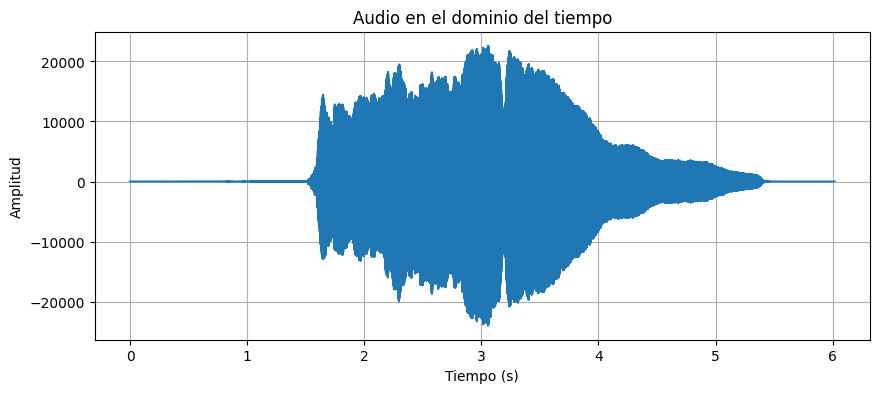

In [1499]:
plt.figure(figsize=(10, 4))
plt.plot(time, audio_signal)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Audio en el dominio del tiempo')
plt.grid()

Text(0.5, 1.0, 'FFT sumada unilateral')

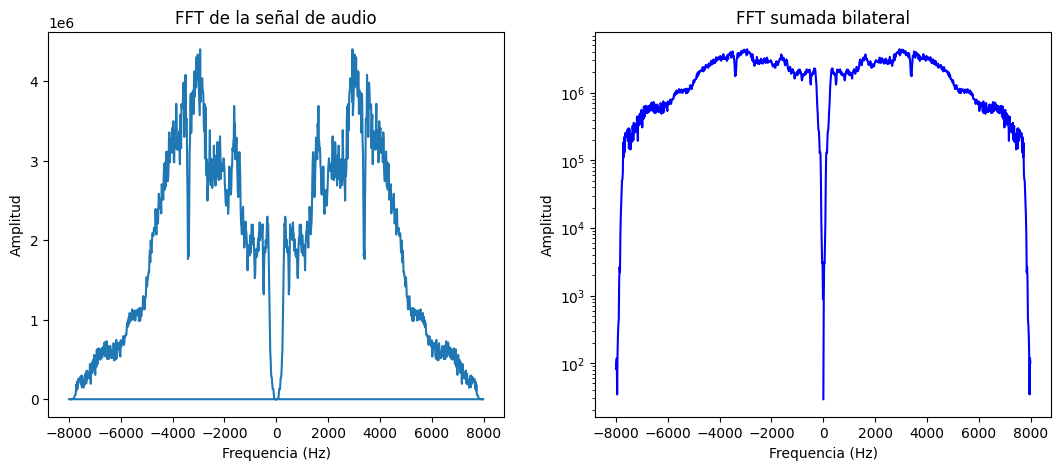

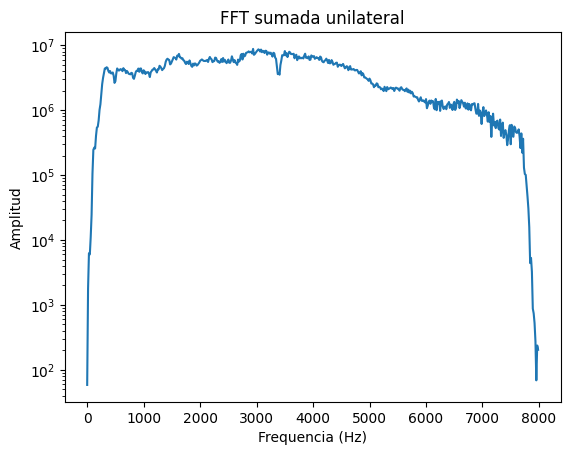

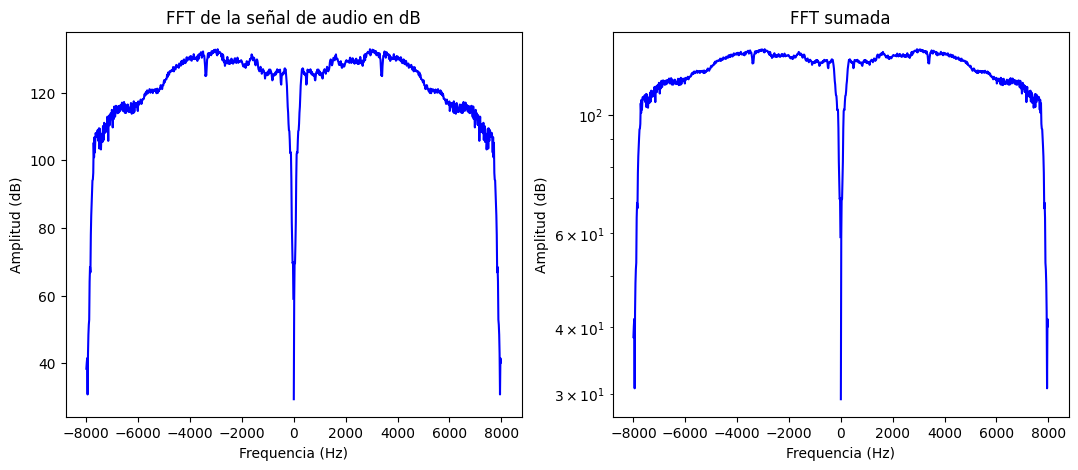

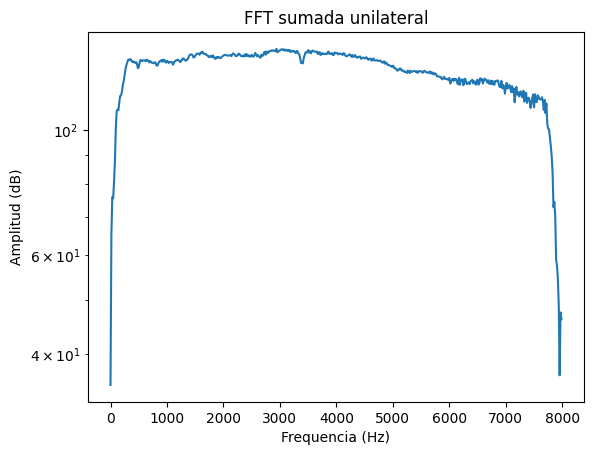

In [1500]:
plt.figure(figsize=(20, 5))


plt.subplot(131)
plt.plot(frequency, np.abs(fft_sum))
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('FFT de la señal de audio')


plt.subplot(132)
plt.plot(frequency[0:512], np.abs(fft_sum)[0:512], color='b')
plt.plot(frequency[512:1024], np.abs(fft_sum)[512:1024], color='b')
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('FFT sumada bilateral')

plt.figure()
plt.plot(frequency[0:512], 2*np.abs(fft_sum)[0:512])
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('FFT sumada unilateral')

#En dB

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(frequency[0:512], 20 * np.log10(np.abs(fft_sum))[0:512], color='b')
plt.plot(frequency[512:1024], 20 * np.log10(np.abs(fft_sum))[512:1024], color='b')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('FFT de la señal de audio en dB')

plt.subplot(132)
plt.plot(frequency[0:512], 20 * np.log10(np.abs(fft_sum))[0:512], color='b')
plt.plot(frequency[512:1024],20 * np.log10(np.abs(fft_sum))[512:1024], color='b')
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('FFT sumada')

plt.figure()
plt.plot(frequency[0:512], 20*np.log10(2*np.abs(fft_sum))[0:512])
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('FFT sumada unilateral')

### Espectro de potencia de la señal

Text(0, 0.5, 'Densidad espectral de potencia unilateral(dB)')

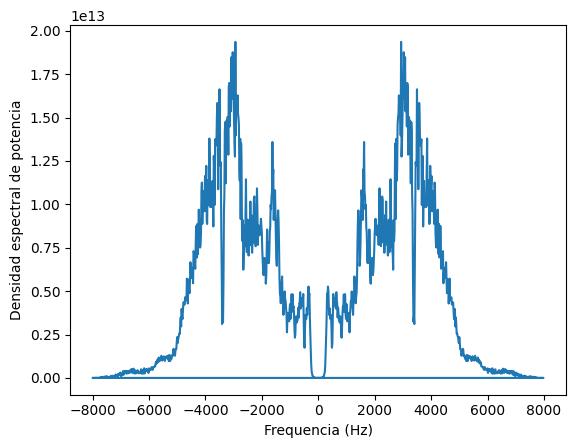

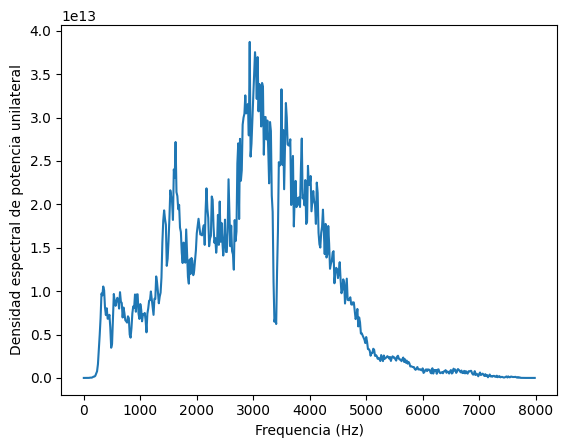

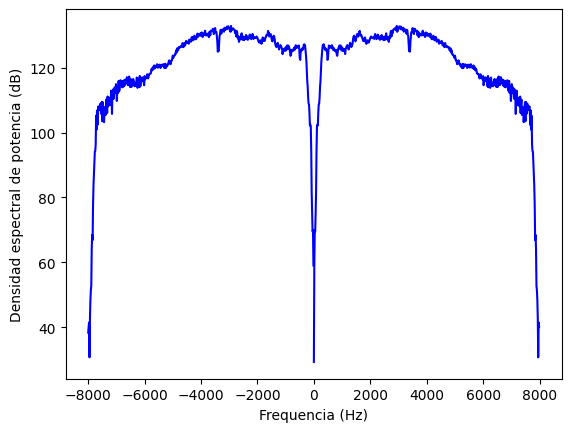

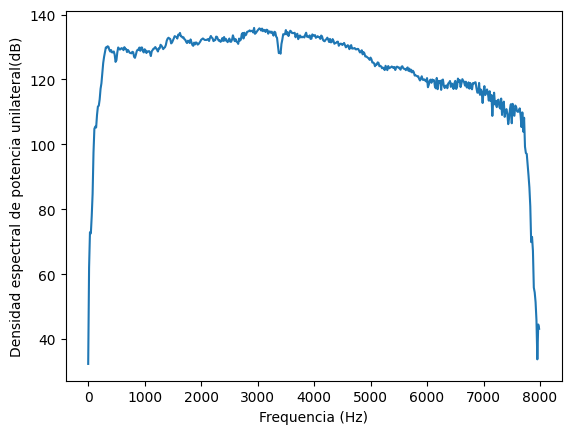

In [1501]:
power_spectrum = np.abs(fft_sum)**2
plt.figure()
plt.plot(frequency, power_spectrum)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Densidad espectral de potencia')

plt.figure()
plt.plot(frequency[0:512], 2*power_spectrum[0:512])
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Densidad espectral de potencia unilateral')

#En dB
power_spectrum = np.abs(fft_sum)**2
plt.figure()
plt.plot(frequency[0:512], 10 * np.log10(power_spectrum)[0:512], color='b')
plt.plot(frequency[512:1024], 10 * np.log10(power_spectrum)[512:1024],color='b')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Densidad espectral de potencia (dB)')


plt.figure()
plt.plot(frequency[0:512], 10 * np.log10(2*power_spectrum)[0:512])
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Densidad espectral de potencia unilateral(dB)')

Text(0, 0.5, 'Densidad espectral de potencia unilateral (dB)')

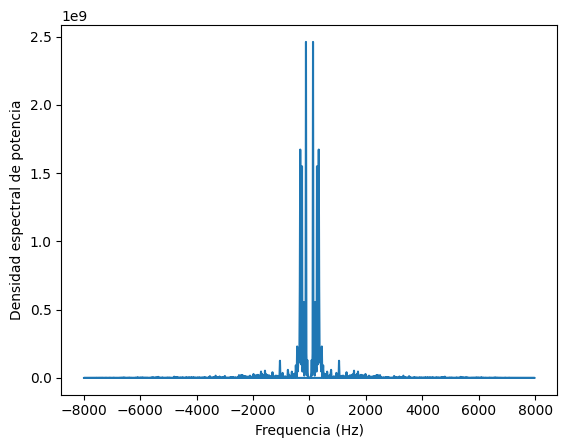

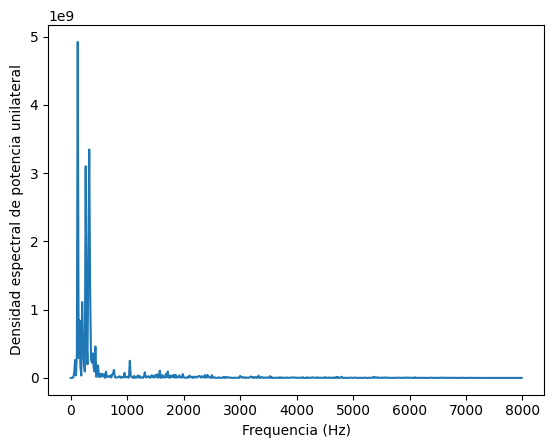

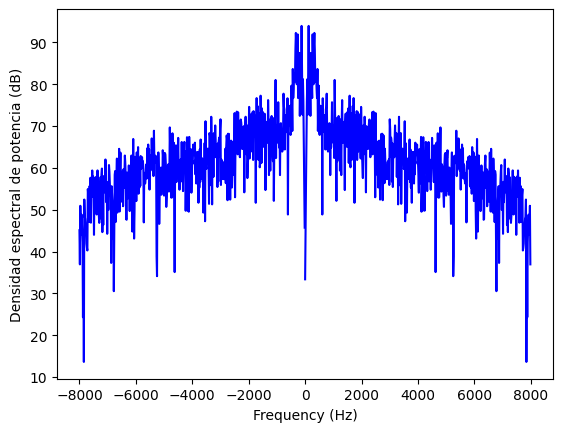

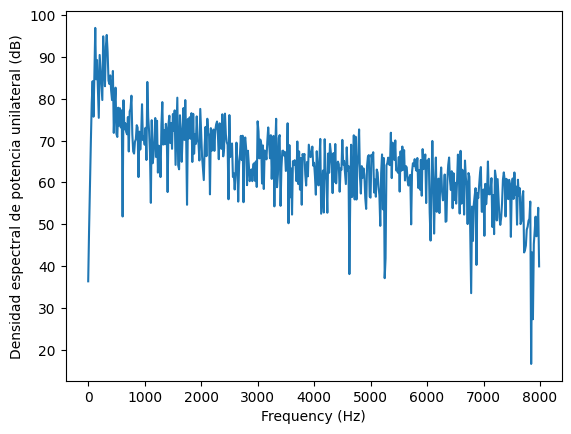

In [1502]:
power_spectrum_ruido = np.abs(fft_sum_)**2

N = len(power_spectrum_ruido)
new_frequency = np.fft.fftfreq(N, d=1.0/silencio.frame_rate)

plt.figure()
plt.plot(new_frequency, power_spectrum_ruido)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Densidad espectral de potencia')

plt.figure()
plt.plot(new_frequency[0:512], 2*power_spectrum_ruido[0:512])
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Densidad espectral de potencia unilateral')
#En dB

plt.figure()
plt.plot(new_frequency[0:512], 10 * np.log10(power_spectrum_ruido)[0:512],color='b')
plt.plot(new_frequency[512:1024], 10 * np.log10(power_spectrum_ruido)[512:1024],color='b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Densidad espectral de potencia (dB)')

plt.figure()
plt.plot(new_frequency[0:512], 10 * np.log10(2*power_spectrum_ruido)[0:512])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Densidad espectral de potencia unilateral (dB)')


In [1503]:
plt.show()

In [1504]:
fixed = np.concatenate((new_frequency[512:1024],new_frequency[0:511]), axis=None)
fixed[0:1024]

array([-8000.   , -7984.375, -7968.75 , ...,  7937.5  ,  7953.125,
        7968.75 ])

## Filtro paso bajos con fc = 5kHz

In [1505]:
from scipy import signal

def low_pass_filter(input_signal, cutoff=5000, fs=44100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.filtfilt(b, a, input_signal)
    return filtered_signal


### Aplicando filtro

In [1506]:
filtered_power_spectrum = low_pass_filter(power_spectrum)
filtered_power_spectrum_ruido = low_pass_filter(power_spectrum_ruido)
for i in range(len(filtered_power_spectrum)):
    if filtered_power_spectrum[i] < 0:
        filtered_power_spectrum[i] = -filtered_power_spectrum[i]
for i in range(len(filtered_power_spectrum_ruido)):
    if filtered_power_spectrum_ruido[i] < 0:
        filtered_power_spectrum_ruido[i] = -filtered_power_spectrum_ruido[i]

#### Graficando

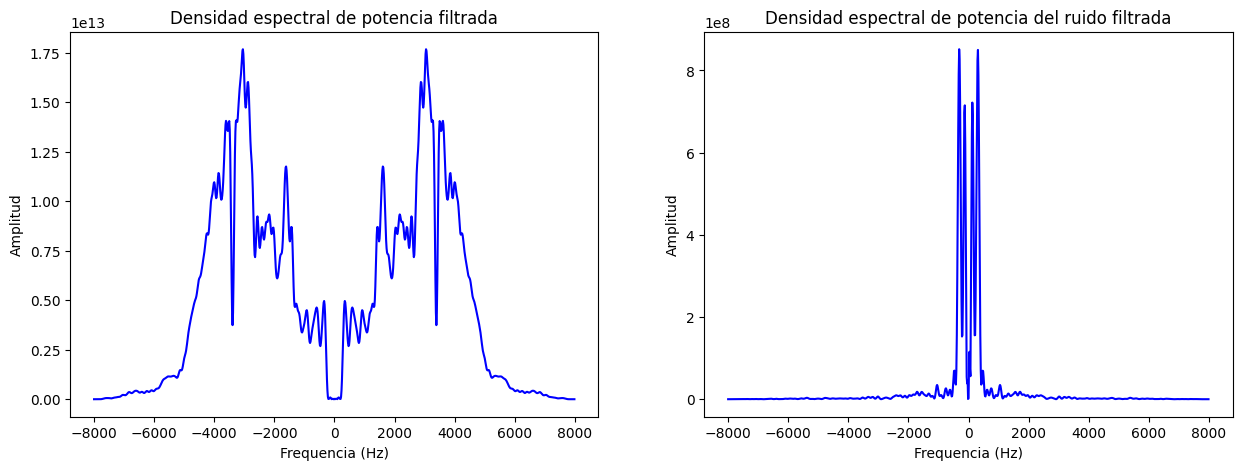

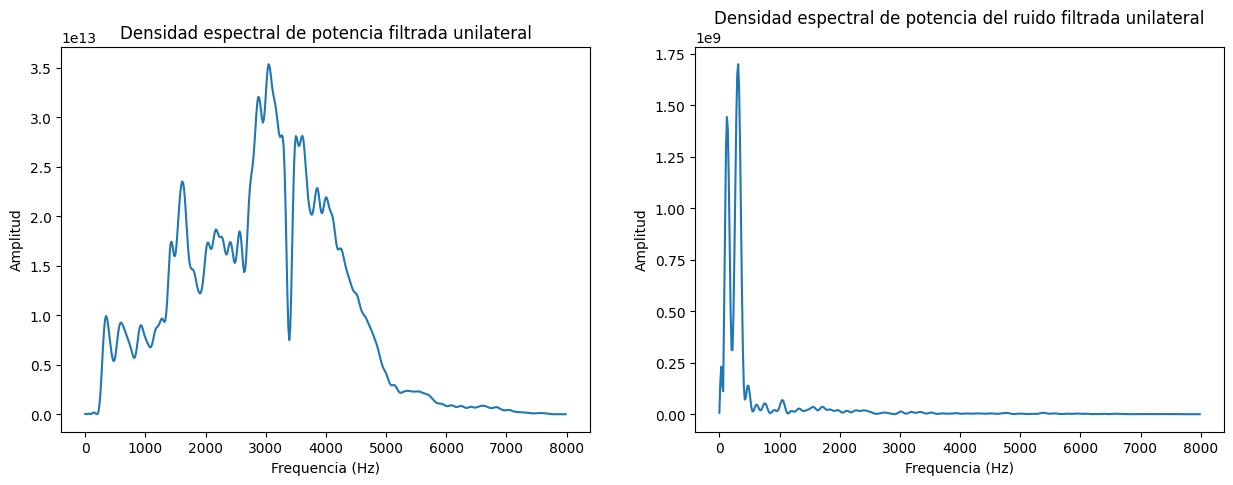

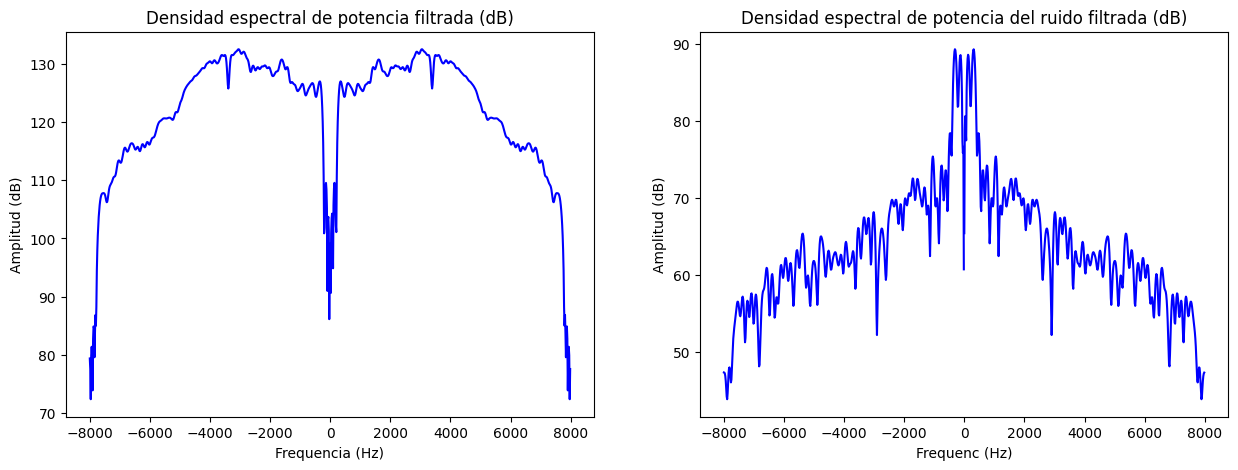

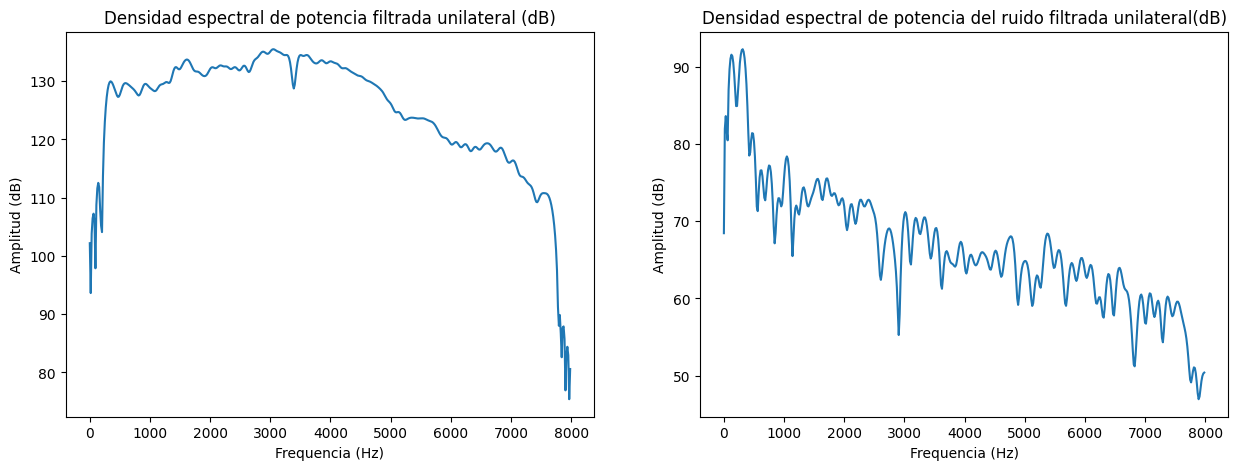

In [1507]:
N = len(filtered_power_spectrum_ruido)
new_frequency = np.fft.fftfreq(N, d=1.0/silencio.frame_rate)

plt.figure(figsize=(15, 5))

# Plot 1: Filtered power_spectrum
plt.subplot(121)
plt.plot(frequency[0:512], filtered_power_spectrum[0:512], color='b')
plt.plot(frequency[512:1024], filtered_power_spectrum[512:1024], color='b')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Densidad espectral de potencia filtrada')

# Plot 2: Filtered power_spectrum_ruido
plt.subplot(122)
plt.plot(new_frequency[0:512], filtered_power_spectrum_ruido[0:512], color='b')
plt.plot(new_frequency[512:1024], filtered_power_spectrum_ruido[512:1024], color='b')
#plt.plot(new_frequency, filtered_power_spectrum_ruido)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Densidad espectral de potencia del ruido filtrada')

plt.figure(figsize=(15, 5))

# Plot 1: Filtered power_spectrum
plt.subplot(121)
plt.plot(frequency[0:512], 2*(filtered_power_spectrum[0:512]))
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Densidad espectral de potencia filtrada unilateral')

# Plot 2: Filtered power_spectrum_ruido
plt.subplot(122)
plt.plot(new_frequency[0:512], 2*filtered_power_spectrum_ruido[0:512])
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Densidad espectral de potencia del ruido filtrada unilateral')

plt.show()

plt.figure(figsize=(15, 5))

# Plot 1: Filtered power_spectrum in dB
plt.subplot(121)
plt.plot(frequency[0:512], 10 * np.log10(filtered_power_spectrum[0:512]), color='b')
plt.plot(frequency[512:1024], 10 * np.log10(filtered_power_spectrum[512:1024]), color='b')
#plt.plot(frequency, 10 * np.log10(filtered_power_spectrum))
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('Densidad espectral de potencia filtrada (dB)')

# Plot 2: Filtered power_spectrum_ruido in dB
plt.subplot(122)
plt.plot(new_frequency[0:512], 10 * np.log10(filtered_power_spectrum_ruido)[0:512], color='b')
plt.plot(new_frequency[512:1024], 10 * np.log10(filtered_power_spectrum_ruido)[512:1024], color='b')
#plt.plot(new_frequency, 10 * np.log10(filtered_power_spectrum_ruido))
plt.xlabel('Frequenc (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('Densidad espectral de potencia del ruido filtrada (dB)')

plt.show()

plt.figure(figsize=(15, 5))

# Plot 1: Filtered power_spectrum in dB
plt.subplot(121)
plt.plot(frequency[0:512], 10 * np.log10(2*filtered_power_spectrum[0:512]))
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('Densidad espectral de potencia filtrada unilateral (dB)')

# Plot 2: Filtered power_spectrum_ruido in dB
plt.subplot(122)
plt.plot(new_frequency[0:512], 10 * np.log10(2*filtered_power_spectrum_ruido[0:512]))
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('Densidad espectral de potencia del ruido filtrada unilateral(dB)')

plt.show()


### Calculo de potencia total

In [1508]:
potencia_total_señal = 10*np.log10(sum(filtered_power_spectrum))
potencia_total_ruido = 10*np.log10(sum(filtered_power_spectrum_ruido))

In [1509]:
SNR= potencia_total_señal-potencia_total_ruido
print(SNR)

52.973631368858335


## Ecualizador

### Ganancias de los filtros por cada audio

#### Para audio "ruidov3.wav"

In [1510]:
g1 = 0.7
g2 = 0.7
g3 = 0.8
g4 = 0.5
g5 = 1.5
g6 = 2

#### Para audio "microfono.wav"

g1 = 2.8
g2 = 2.6
g3 = 0.3
g4 = 0.05
g5 = 0.01
g6 = 0.05

### Filtros

In [1511]:
from scipy.io import wavfile

N=60
filtro1 = [0.4, 0.5]
filtro2 = [0.3, 0.4]
filtro3 = [0.25, 0.3]
filtro4 = [0.2, 0.25]
filtro5 = [0.1, 0.2]
filtro6 = 0.1

pasa_banda4=signal.firwin(N,filtro1,pass_zero=False)
x_BPF4=signal.lfilter(pasa_banda4,[1.0],audio_signal)
ganancia_BPF4=g1
bpf4=ganancia_BPF4*x_BPF4

pasa_banda0=signal.firwin(N,filtro2,pass_zero=False)
x_BPF0=signal.lfilter(pasa_banda0,[1.0],audio_signal)
ganancia_BPF0=g2
bpf0=ganancia_BPF0*x_BPF0

pasa_banda1=signal.firwin(N,filtro3,pass_zero=False)
x_BPF1=signal.lfilter(pasa_banda1,[1.0],audio_signal)
ganancia_BPF1=g3
bpf1=ganancia_BPF1*x_BPF1

pasa_banda2=signal.firwin(N,filtro4,pass_zero=False)
x_BPF2=signal.lfilter(pasa_banda2,[1.0],audio_signal)
ganancia_BPF2=g4
bpf2=ganancia_BPF2*x_BPF2

pasa_banda3=signal.firwin(N,filtro5,pass_zero=False)
x_BPF3=signal.lfilter(pasa_banda3,[1.0],audio_signal)
ganancia_BPF3=g5
bpf3=ganancia_BPF3*x_BPF3

pasa_bajas=signal.firwin(N,filtro6,pass_zero=True)
x_LPF=signal.lfilter(pasa_bajas,[1.0],audio_signal)
ganancia_LPF= g6
lpf=ganancia_LPF*x_LPF

senal_ecualizada=lpf+bpf0+bpf1+bpf2+bpf3+bpf4

wavfile.write('senal_ecualizada.wav', frame_rate, senal_ecualizada.astype(np.int16))

### Ventana de Hamming al audio ecualizado

In [1512]:
audio_ecualizado = AudioSegment.from_file("senal_ecualizada.wav")
signal_equalized = np.array(audio_ecualizado.get_array_of_samples())
window = get_window('hamming', len(signal_equalized))
audio_signal_equalized = apply_window(signal_equalized, window)
frame_rate = audio_ecualizado.frame_rate
time_equalized = np.arange(len(audio_signal_equalized)) / float(frame_rate)
bin_size = 1024
num_bins = len(audio_signal_equalized) // bin_size
bins = np.array_split(audio_signal_equalized, num_bins)
fft_bins = [fft(bin) for bin in bins]
max_size = max([len(bin) for bin in fft_bins])
fft_bins_padded = [np.pad(bin, (0, max_size - len(bin)), 'constant') for bin in fft_bins]
fft_sum_equalized = np.sum(fft_bins_padded, axis=0)
frequency_equalized = np.fft.fftfreq(max_size, d=1.0/frame_rate)

### Gráficas de señal ecualizada

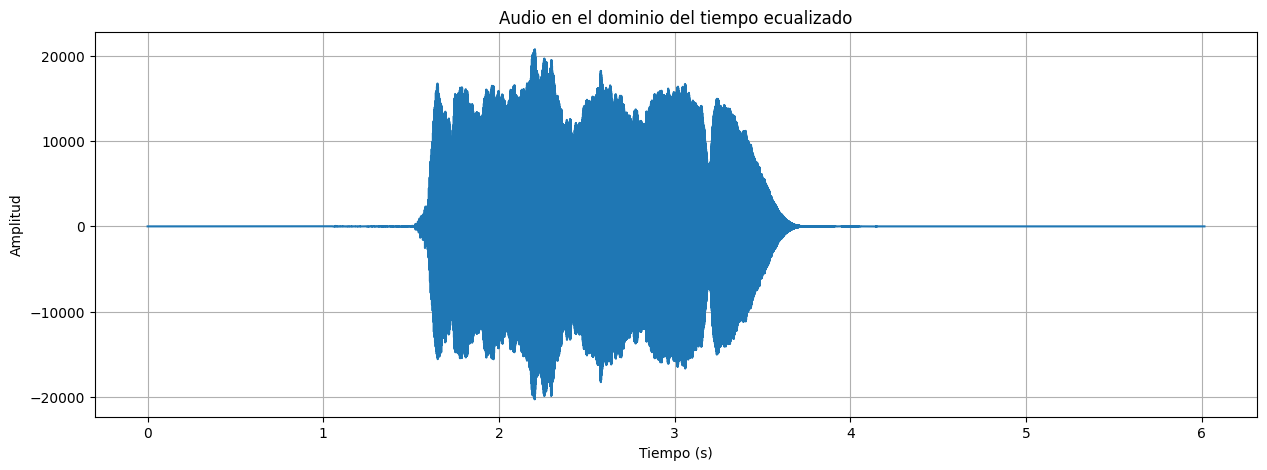

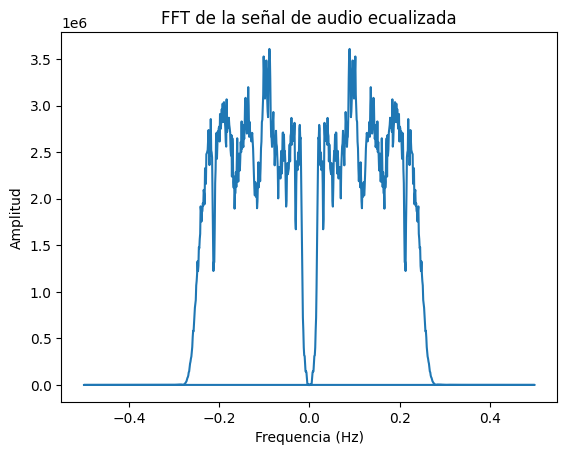

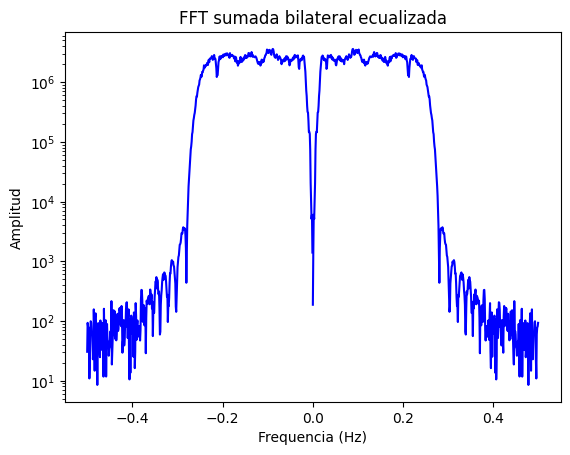

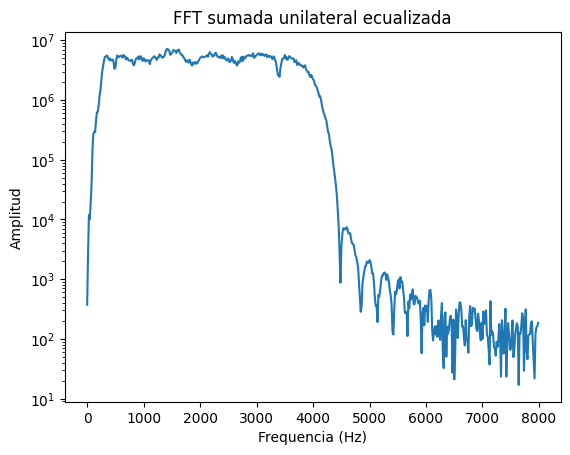

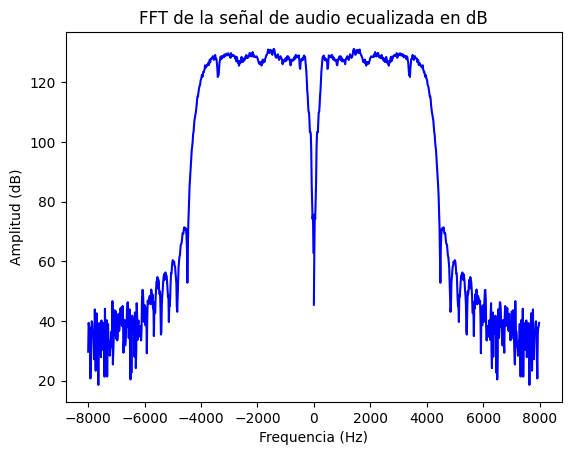

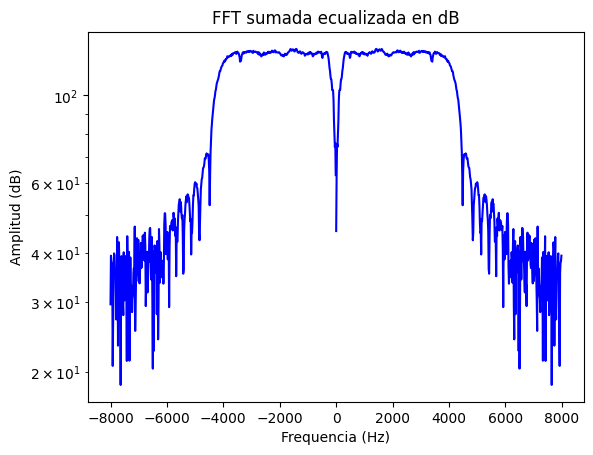

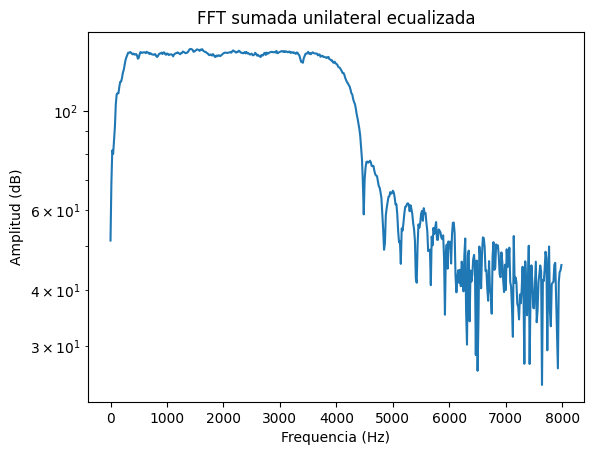

In [1513]:
half = int(len(fft_sum)/2)
plt.figure(figsize=(15, 5))
plt.plot(time_equalized, audio_signal_equalized)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Audio en el dominio del tiempo ecualizado')
plt.grid()

plt.figure()
plt.plot(frequency_equalized/frame_rate, np.abs(fft_sum_equalized))
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('FFT de la señal de audio ecualizada')

plt.figure()
plt.plot((frequency_equalized/frame_rate) [0:half], np.abs(fft_sum_equalized)[0:half], color='b')
plt.plot((frequency_equalized/frame_rate) [half:half*2], np.abs(fft_sum_equalized)[half:half*2], color='b')
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('FFT sumada bilateral ecualizada')

plt.figure()
plt.plot(frequency_equalized[0:half], 2*np.abs(fft_sum_equalized)[0:half])
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud')
plt.title('FFT sumada unilateral ecualizada')


plt.figure()
plt.plot(frequency_equalized[0:half], 20 * np.log10(np.abs(fft_sum_equalized))[0:half], color='b')
plt.plot(frequency_equalized[half:half*2], 20 * np.log10(np.abs(fft_sum_equalized))[half:half*2], color='b')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('FFT de la señal de audio ecualizada en dB')

plt.figure()
plt.plot(frequency_equalized[0:half], 20 * np.log10(np.abs(fft_sum_equalized))[0:half], color='b')
plt.plot(frequency_equalized[half:half*2], 20 * np.log10(np.abs(fft_sum_equalized))[half:half*2], color='b')
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('FFT sumada ecualizada en dB')

plt.figure()
plt.plot(frequency_equalized[0:half], 20*np.log10(2*np.abs(fft_sum_equalized))[0:half])
plt.semilogy()
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title('FFT sumada unilateral ecualizada')
plt.show()

## Usando referencia de senoidal de 1kHz

In [1514]:
audio = AudioSegment.from_file("referenciav3.wav")
signal_ = np.array(audio.get_array_of_samples())
window = get_window('hamming', len(signal_))
signal = apply_window(signal_, window)

frame_rate = audio.frame_rate
time = np.arange(len(signal)) / float(frame_rate)
bin_size = 1024
num_bins = len(signal) // bin_size
bins = np.array_split(signal, num_bins)

fft_bins = [fft(bin) for bin in bins]
max_size = max([len(bin) for bin in fft_bins])
fft_bins_padded = [np.pad(bin, (0, max_size - len(bin)), 'constant') for bin in fft_bins]
fft_sum = np.sum(fft_bins_padded, axis=0)
frequency = np.fft.fftfreq(max_size, d=1.0/frame_rate)

In [1515]:
power_spectrum = np.abs(fft_sum)**2
potencia_1khz = 10*np.log10(sum(power_spectrum))

In [1516]:
SNR= potencia_1khz-potencia_total_ruido
print(SNR)

67.67890812746269
